# Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [1]:
import numpy as np
D = np.loadtxt('data/lin_reg.txt', delimiter=',')
X = D[:, :-1]
y = D[:, -1]

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [6]:
import torch

X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

X = torch.hstack((torch.ones(X.shape[0], 1), X))

In [8]:
def qwe(y_true, y_pred):
    return (y_true - y_pred).pow(2).mean()

In [13]:
from tqdm.notebook import tqdm

class LinearRegression:
    def __init__(self, lr=0.001, momentum=0.9, loss=qwe, regulization="L2", C=0.1, epochs=100, batch_size=100):
        self.lr = lr
        self.momentum = momentum
        self.loss = loss
        self.reguliztion = regulization
        self.C = C
        self.batch_size=batch_size
        
        self.theta = None
        self.losses = None
        self.prev_grad = 0
        self.epochs = 100
        
    def fit(self, X, y, disable_bar=False):
        self.theta = torch.rand(X.shape[1], requires_grad=True)
        
        epoch = 0
        self.losses = []
        n_iters = X.shape[0] // self.batch_size
        
        for epoch in tqdm(range(self.epochs), disable=disable_bar):
            loss_acc = 0
            for i in range(n_iters):
                y_pred = X[i * self.batch_size: (i + 1) * self.batch_size] @ self.theta
                loss = self.loss(y[i * self.batch_size: (i + 1) * self.batch_size], y_pred)

                if self.reguliztion == "L2":
                    loss += self.C * torch.norm(self.theta)

                loss.backward()

                with torch.no_grad():
                    loss_acc += loss.item()

                    grad = self.lr * self.theta.grad
                    if self.momentum:
                        grad += self.momentum * self.prev_grad

                    self.theta -= grad
                    self.prev_grad = grad

                    self.theta.grad.zero_()
                        
            self.losses.append(loss_acc / n_iters)

    
    def predict(self, X):
        return X @ self.theta

In [17]:
reg = LinearRegression(lr=0.0005, C=1, momentum=0.9, batch_size=100)


reg.fit(X, y)

In [18]:
y_pred = reg.predict(X)

qwe(y, y_pred)

tensor(95.1545, grad_fn=<MeanBackward0>)

No handles with labels found to put in legend.


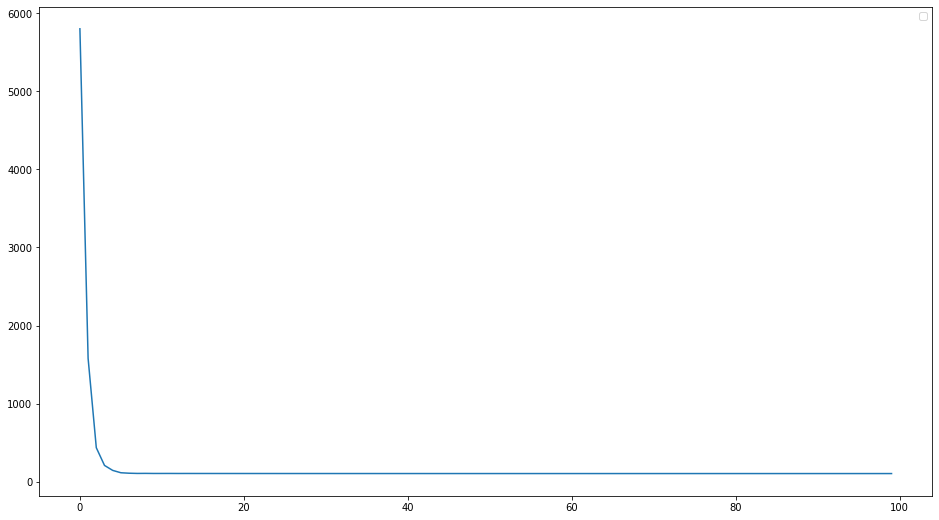

In [19]:
from matplotlib import pyplot as plt


def plot_losses(reg):
    plt.plot(reg.losses)

plt.figure(figsize=(16, 9))
plot_losses(reg)
plt.legend()
plt.show()

In [21]:
c_losses = []
train_losses = []
cs = np.arange(0.01, 10, 0.3)

for C in cs:
    reg = LinearRegression(C=C)

    reg.fit(X, y, disable_bar=True)
    
    y_pred = reg.predict(X)
    c_losses.append(qwe(y, y_pred))

In [20]:
def plot_C(losses, Cs):
    plt.plot(cs, losses)

No handles with labels found to put in legend.


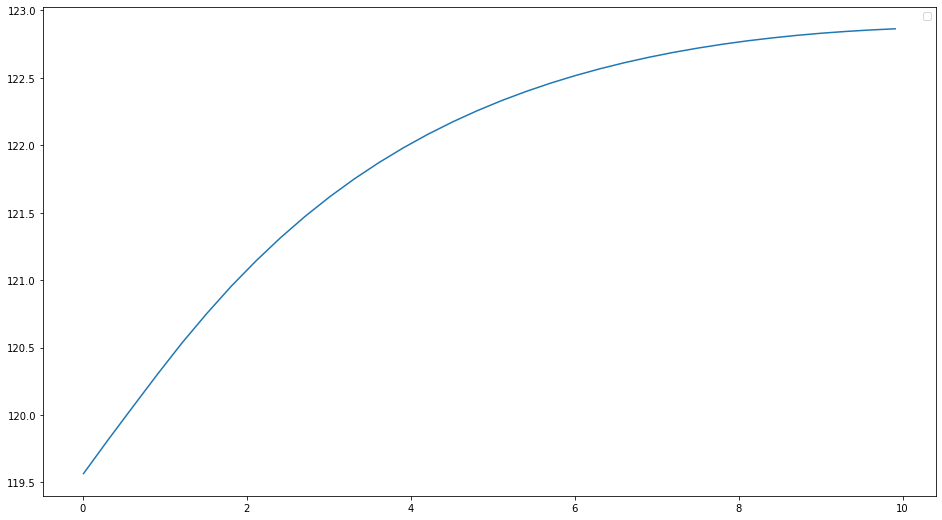

In [22]:
plt.figure(figsize=(16, 9))
plot_C(c_losses, cs)
plt.legend()
plt.show()

In [23]:
class CrossVal:
    def __init__(self, n_items, n_splits=5):
        self.n_items = n_items
        self.n_splits = n_splits
    
    def splits(self):
        indicies = np.arange(self.n_items)
        split_size = self.n_items // self.n_splits
        
        for i in range(self.n_splits):
            train_indicies = indicies[0: i * split_size]
            train_indicies = np.hstack((train_indicies, indicies[(i+1) * split_size:]))
            
            val_indicies = indicies[i * split_size: (i + 1) * split_size]
            yield (train_indicies, val_indicies)
            

In [24]:
def cross_val_score(Regressor, X, y, n_splits=5, **params):
    reg = Regressor(**params)
    
    scores = np.zeros(n_splits)
    train_scores = np.zeros(n_splits)
    cv = CrossVal(X.shape[0])

    for i, (train_indicies, val_indicies) in enumerate(cv.splits()):
        reg.fit(X[train_indicies], y[train_indicies], disable_bar=True)
        y_pred = reg.predict(X[val_indicies])
        scores[i] = qwe(y[val_indicies], y_pred)
        y_pred = reg.predict(X[train_indicies])
        train_scores[i] = qwe(y[train_indicies], y_pred)
        
    return scores, train_scores


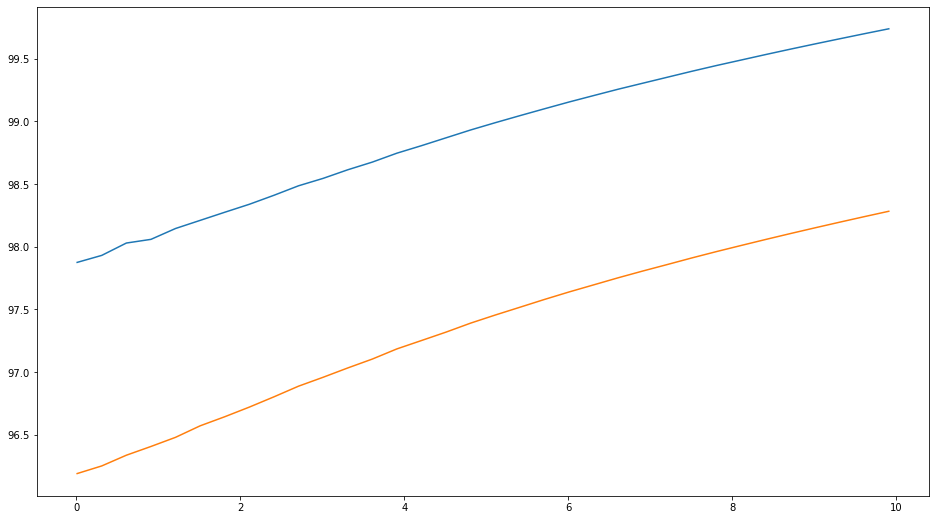

In [25]:
c_losses = []
train_losses = []
cs = np.arange(0.01, 10, 0.3)

for C in cs:
    scores, train_scores = cross_val_score(LinearRegression, X, y, C=C, momentum=0.8)
    c_losses.append(scores.mean())
    train_losses.append(train_scores.mean())
    
plt.figure(figsize=(16, 9))
plot_C(c_losses, cs)
plot_C(train_losses, cs)
plt.show()

In [26]:
import random

class RandomSearchCV:
    def __init__(self, n_trials, params_bound, n_splits=5):
        self.n_trials = n_trials
        self.params_bound = params_bound
        self.n_splits = n_splits
        
    def search(self, Regressor, X, y):
        scores = []
        for i in tqdm(range(self.n_trials)):
            params = {
                key: random.uniform(v[0], v[1])
                for key, v in self.params_bound.items()
            }
            scores.append({
                "params": params,
                "scores": cross_val_score(Regressor, X, y, n_splits=self.n_splits, **params)[0].mean()
            })
        return scores

In [27]:
search = RandomSearchCV(100, {
    "lr": (0.001, 0.00001),
    "C": (0.1, 10),
    "momentum": (0.5, 0.95)
})

results = search.search(LinearRegression, X, y)

In [28]:
sorted(results, key=lambda x: x["scores"])[0]

{'params': {'C': 1.9572447585015202,
  'lr': 0.00010272853007986006,
  'momentum': 0.9451691901358553},
 'scores': 96.90280303955078}